In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint, uniform

In [2]:
# df_old_analysis = pd.read_csv(r"..\1_Data\df_analysis.csv")
df_original = pd.read_csv(r"..\1_Data\df_cleaned.csv")
df_analysis = df_original.copy()
df_ML = df_analysis.copy()

In [3]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37583 entries, 0 to 37582
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fullAddress            37583 non-null  object 
 1   postcode               37583 non-null  object 
 2   country                37583 non-null  object 
 3   outcode                37583 non-null  object 
 4   latitude               37583 non-null  float64
 5   longitude              37583 non-null  float64
 6   bathrooms              37583 non-null  float64
 7   bedrooms               37583 non-null  float64
 8   floorAreaSqM           37583 non-null  float64
 9   livingRooms            37583 non-null  float64
 10  tenure                 37583 non-null  object 
 11  propertyType           37583 non-null  object 
 12  currentEnergyRating    37583 non-null  object 
 13  soldYear               37583 non-null  int64  
 14  soldT                  37583 non-null  object 
 15  so

In [4]:
low = df_ML['sqmPrice'].quantile(0.01)
high = df_ML['sqmPrice'].quantile(0.95)
df_ML = df_ML[(df_ML['sqmPrice'] > low) & (df_ML['sqmPrice'] < high)]

In [5]:
# 1. Total Rooms
df_ML['total_rooms'] = df_ML['bedrooms'] + df_ML['livingRooms']

# 2. Spatial Quality (No +0.1, as requested)
# Logic: A 60sqm house with 2 rooms (score 30) is a "Spacious Apartment".
#        A 60sqm house with 3 rooms (score 20) is a "Compact Apartment".
#        The model uses this to determine the "Style" of the property.
df_ML['spatial_quality'] = df_ML['floorAreaSqM'] / df_ML['total_rooms']

# 3. Luxury Index
# Logic: For small houses, this will mostly be 1.0 (Standard).
#        For big houses, 1.0 becomes rare and valuable.
#        The model uses Area + Index together to judge luxury.
#        We keep +0.1 here just in case a studio is listed as 0 bedrooms (studio flat)
df_ML['luxury_index'] = df_ML['bathrooms'] / (df_ML['bedrooms'] + 0.1)

In [6]:
df_ML.describe()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,soldYear,soldPrice,sqmPrice,in_conservation_area,sqm_approx,total_rooms,spatial_quality,luxury_index
count,35327.000000,35327.000000,35327.000000,35327.000000,35327.000000,35327.000000,35327.000000,3.532700e+04,35327.000000,35327.000000,35327.000000,35327.000000,35327.000000,35327.000000
mean,51.509194,-0.114964,1.446910,2.362074,97.923175,1.223427,2023.332494,7.032616e+05,7047.742449,0.264925,97.908823,3.585501,27.045225,0.667402
std,0.057635,0.090339,0.680987,1.275964,56.827242,0.582091,0.471113,5.466174e+05,2345.889320,0.441299,56.854057,1.695309,6.149300,0.257620
min,51.386653,-0.347055,1.000000,1.000000,13.000000,0.000000,2023.000000,6.900000e+04,2022.060000,0.000000,15.000000,1.000000,11.250000,0.109890
25%,51.463871,-0.183564,1.000000,1.000000,58.000000,1.000000,2023.000000,3.750000e+05,5432.100000,0.000000,60.000000,2.000000,23.000000,0.476190
50%,51.501620,-0.115106,1.000000,2.000000,77.000000,1.000000,2023.000000,5.170000e+05,6734.690000,0.000000,75.000000,3.000000,26.200000,0.645161
75%,51.551437,-0.050388,2.000000,3.000000,127.000000,1.000000,2024.000000,8.450000e+05,8394.195000,1.000000,125.000000,5.000000,29.666667,0.909091
max,51.665454,0.138188,8.000000,9.000000,497.000000,7.000000,2024.000000,6.500000e+06,14236.110000,1.000000,495.000000,14.000000,153.000000,3.636364


In [7]:
# A. Convert Rooms to Integers
room_cols = ['bathrooms', 'bedrooms', 'livingRooms']
df_ML[room_cols] = df_analysis[room_cols].astype(int)

# B. Label Encode Energy Rating (Ordinal: A=7, G=1, NotRated=0)
energy_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1, 'NotRated': np.nan}
df_ML['energy_encoded'] = df_ML['currentEnergyRating'].map(energy_map)

# C. One-Hot Encoding for categorical columns
# Drop the columns not needed
df_ML = df_ML.drop(columns=['soldT'])
df_ML = pd.get_dummies(df_ML, columns=['propertyType', 'tenure', 'construction_age_band'], drop_first=True, prefix=['prop', 'tenure', 'age'])

# D. Define features (X) and targets (y)
X = df_ML.drop(columns=['soldPrice']) 
y = np.log1p(df_ML['soldPrice'])

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target Encode Outcode (using median sqmPrice)
outcode_medians = X_train.groupby('outcode')['sqmPrice'].median()
global_median = X_train['sqmPrice'].median()
X_train['neighborhood_value'] = X_train['outcode'].map(outcode_medians)

X_test['neighborhood_value'] = X_test['outcode'].map(outcode_medians)
X_test['neighborhood_value'] = X_test['neighborhood_value'].fillna(global_median)

# E. Select final features (excluding the original strings and size_bucket)
final_features = [
    'neighborhood_value', 'bathrooms', 'bedrooms', 'floorAreaSqM', 
    'livingRooms', 'energy_encoded', 'tenure_Freehold', 'in_conservation_area', 'latitude', 'longitude', 'spatial_quality', 'luxury_index'
] + [col for col in df_ML.columns if 'propertyType_' in col or 'age' in col.lower()]

X_train = X_train[final_features].astype(float)
X_test = X_test[final_features].astype(float)

In [9]:
# 1. Initialize XGBoost Regressor
# These parameters are "safe defaults" for regression
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    n_estimators=500,        # More trees than Random Forest
    learning_rate=0.05,      # Learn slower but better
    max_depth=6,             # Tree depth
    n_jobs=-1,
    random_state=42
)

# 2. Train
print("Training XGBoost")
xg_reg.fit(X_train, y_train)

# 3. Predict
y_pred_log = xg_reg.predict(X_test)
# Clip extreme values to avoid overflow
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=20)
# Inverse log transform
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

# Metrics
mse  = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_real, y_pred_real)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
r2   = r2_score(y_test_real, y_pred_real)

print("-" * 30)
print("XGBoost Results (Cleaned Data):")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     £{rmse:,.0f}")
print(f"MAE:      £{mae:,.0f}")
print(f"MAPE:     {mape:.2%}")
print("-" * 30)

Training XGBoost
------------------------------
XGBoost Results (Cleaned Data):
R² Score: 0.8825
RMSE:     £179,611
MAE:      £108,268
MAPE:     17.46%
------------------------------


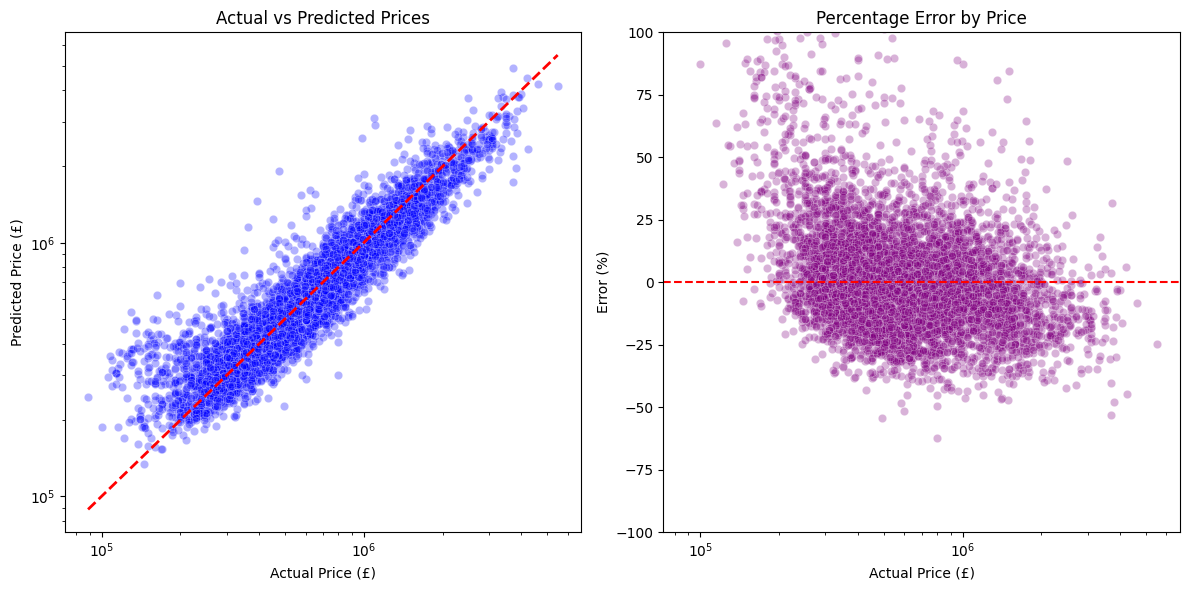

--- Analysis for ~£500k Houses ---
Average Error Amount: £69,840
Average Error %:      13.91%


In [10]:
# Create a DataFrame for plotting
results = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred_real
})

# Calculate the error for each specific house
results['Error_Amount'] = results['Predicted'] - results['Actual']
results['Error_Percent'] = (results['Error_Amount'] / results['Actual']) * 100

plt.figure(figsize=(12, 6))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.3, color='blue')
# Draw a red line for "Perfect Prediction"
plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', lw=2, linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.xscale('log') # Log scale helps see the spread better
plt.yscale('log')

# Plot 2: How big is the error at different price points?
plt.subplot(1, 2, 2)
sns.scatterplot(x='Actual', y='Error_Percent', data=results, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Percentage Error by Price')
plt.xlabel('Actual Price (£)')
plt.ylabel('Error (%)')
plt.xscale('log')
plt.ylim(-100, 100) # Zoom in to +/- 100% error

plt.tight_layout()
plt.show()

# Let's check the error specifically for houses around 500k
subset_500k = results[(results['Actual'] > 450000) & (results['Actual'] < 550000)]
avg_error_500k = subset_500k['Error_Amount'].abs().mean()
avg_mape_500k = subset_500k['Error_Percent'].abs().mean()

print(f"--- Analysis for ~£500k Houses ---")
print(f"Average Error Amount: £{avg_error_500k:,.0f}")
print(f"Average Error %:      {avg_mape_500k:.2f}%")

In [11]:
#  GRID SEARCH + CROSS VALIDATION

# 1. Define the Parameter Grid (The options we want to try)
param_grid = {
    'max_depth': [3, 5, 7],           # 3 is simple, 7 is complex
    'learning_rate': [0.01, 0.05, 0.1], # 0.01 is slow/precise, 0.1 is fast
    'n_estimators': [500, 1000],      # Number of trees
    'subsample': [0.8, 1.0]           # 0.8 means "ignore 20% of data randomly" (helps with outliers!)
}

# 2. Initialize the Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

# 3. Setup the Grid Search
# cv=3 means "Cross Validation": it splits data 3 times to ensure the result isn't luck.
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_absolute_error', verbose=1)

# 4. Train (This will run roughly 3 * 3 * 2 * 2 * 3 = 108 fits!)
print("Starting Hyperparameter Tuning... (Go grab a coffee ☕)")
grid_search.fit(X_train, y_train)

# 5. Get the Best Results
best_params = grid_search.best_params_
print("-" * 30)
print(f"Best Parameters Found: {best_params}")
print("-" * 30)

# 6. Evaluate the Best Model
best_model_gridCV = grid_search.best_estimator_
y_pred_log_gridCV = best_model_gridCV.predict(X_test)
# Reverse the Log Transformation (expm1 = e^x - 1)
y_pred_real_gridCV = np.expm1(y_pred_log_gridCV)
y_test_real_gridCV = np.expm1(y_test)

# General Metrics
r2_gridCV = r2_score(y_test_real_gridCV, y_pred_real_gridCV)
rmse_gridCV = np.sqrt(mean_squared_error(y_test_real_gridCV, y_pred_real_gridCV))
mae_gridCV = mean_absolute_error(y_test_real_gridCV, y_pred_real_gridCV)
mape_gridCV = mean_absolute_percentage_error(y_test_real_gridCV, y_pred_real_gridCV)

print("Results with Tuned Hyperparameters:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     £{rmse:,.0f}")
print(f"MAE:      £{mae:,.0f}")
print(f"MAPE:     {mape:.2%}")

Starting Hyperparameter Tuning... (Go grab a coffee ☕)
Fitting 3 folds for each of 36 candidates, totalling 108 fits
------------------------------
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
------------------------------
Results with Tuned Hyperparameters:
R² Score: 0.8825
RMSE:     £179,611
MAE:      £108,268
MAPE:     17.46%


In [12]:
# RANDOM SEARCH + CROSS VALIDATION

# 1. Define the Parameter Distribution
# We widen the search space to include Regularization (alpha/lambda) to fight outliers
param_dist = {
    'n_estimators': randint(200, 1000),      # Any number of trees between 200 and 1000
    'max_depth': randint(3, 10),             # Depths between 3 and 10
    'learning_rate': uniform(0.01, 0.2),     # Any rate between 0.01 and 0.21
    'subsample': uniform(0.6, 0.4),          # Randomly choose between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4),   # Randomly choose % of columns per tree
    'min_child_weight': randint(1, 10),      # CRITICAL: Controls outlier sensitivity
    'reg_alpha': uniform(0, 5),              # L1 Regularization (removes noise)
    'reg_lambda': uniform(0, 5)              # L2 Regularization (reduces extreme weights)
}

# 2. Initialize Base Model
# n_jobs=1 here because the RandomizedSearchCV will handle parallel processing
xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)

# 3. Setup Random Search
# n_iter=50 means we try 50 random combinations
random_search_xg = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# 4. Train (Fit)
print("Starting XGBoost Random Search (Searching for the perfect noise settings)...")
random_search_xg.fit(X_train, y_train)

# 5. Get the Winner
best_xg_rand = random_search_xg.best_estimator_
print("-" * 30)
print(f"Best Parameters: {random_search_xg.best_params_}")
print("-" * 30)

# 6. Predict
y_pred_log_xg_randCV = best_xg_rand.predict(X_test)

# 7. Reverse Log
y_test_real_xg_randCV = np.expm1(y_test)
y_pred_real_xg_randCV = np.expm1(y_pred_log_xg_randCV)

# 8. Metrics
mse_xg_randCV  = mean_squared_error(y_test_real_xg_randCV, y_pred_real_xg_randCV)
rmse_xg_randCV = np.sqrt(mse_xg_randCV)
mae_xg_randCV  = mean_absolute_error(y_test_real_xg_randCV, y_pred_real_xg_randCV)
mape_xg_randCV = mean_absolute_percentage_error(y_test_real_xg_randCV, y_pred_real_xg_randCV)
r2_xg_randCV   = r2_score(y_test_real_xg_randCV, y_pred_real_xg_randCV)

# 9. Display
print("Model Performance (XGBoost Random Search):")
print("-" * 30)
print(f"R² Score: {r2_xg_randCV:.4f}")
print(f"RMSE:     £{rmse_xg_randCV:,.0f}")
print(f"MAE:      £{mae_xg_randCV:,.0f}")
print(f"MAPE:     {mape_xg_randCV:.2%}")
print("-" * 30)

Starting XGBoost Random Search (Searching for the perfect noise settings)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
------------------------------
Best Parameters: {'colsample_bytree': np.float64(0.6777095814048169), 'learning_rate': np.float64(0.024188183399985533), 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 670, 'reg_alpha': np.float64(0.13808385936852352), 'reg_lambda': np.float64(2.8943244775377934), 'subsample': np.float64(0.7753896492072347)}
------------------------------
Model Performance (XGBoost Random Search):
------------------------------
R² Score: 0.8867
RMSE:     £176,380
MAE:      £106,402
MAPE:     17.15%
------------------------------
